In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect,func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
MSM=Base.classes.measurement
stations=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
inspector=inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [11]:
msm_cols=inspector.get_columns('measurement')
for col in msm_cols:
    print(col['name'],col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
sta_cols=inspector.get_columns('station')
for col in sta_cols:
    print(col['name'],col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [24]:
# last Date
lastdate=session.query(MSM.date).order_by(MSM.date.desc()).first()
lastdate

('2017-08-23')

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
date12month=dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last12month_results=session.query(func.strftime("%Y-%m-%d", MSM.date),MSM.prcp).\
              filter(func.strftime("%Y-%m-%d", MSM.date)>=dt.date(2016,8,23)).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp12_df=pd.DataFrame(last12month_results,columns=['date','precipitation'])
#prcp12_df.set_index('date',inplace=True)
prcp12_df['date'] = pd.to_datetime(prcp12_df['date'])
prcp12_df.dtypes

date             datetime64[ns]
precipitation           float64
dtype: object

In [39]:
#Sort the DataFrame values by date.
sorted12_df=prcp12_df.sort_values(by=['date'])
sorted12_df.set_index('date',inplace=True)
sorted12_df.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


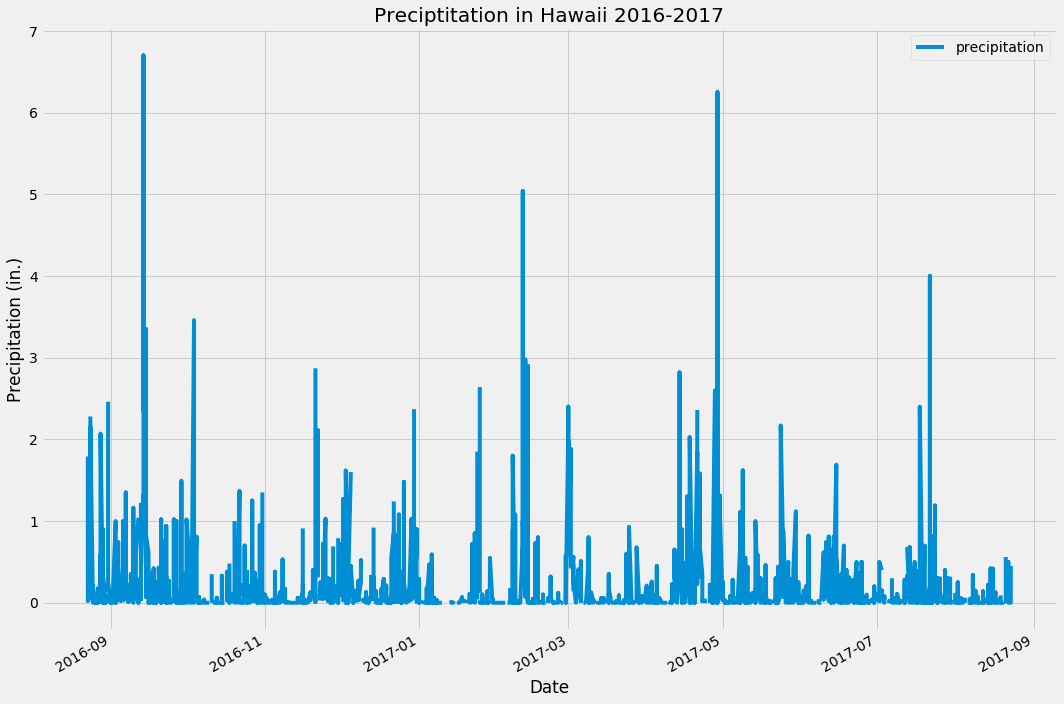

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 10))
sorted12_df.plot(ax = ax)

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Preciptitation in Hawaii 2016-2017")

plt.savefig("precipitation.png")

#plot
plt.tight_layout()
plt.show()

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted12_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [56]:
# Design a query to show how many stations are available in this dataset?
unique_stations=session.query(MSM.station).distinct().count()
print(unique_stations)

9


In [57]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count=session.query(MSM.station,func.count(MSM.id)).group_by(MSM.station).\
       order_by(func.count(MSM.id).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
tempby_281=session.query(func.min(MSM.tobs),func.max(MSM.tobs),func.avg(MSM.tobs)).\
        filter(MSM.station=='USC00519281').all()
tempby_281

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Temperature Frequency: USC00519281 2016-2017')

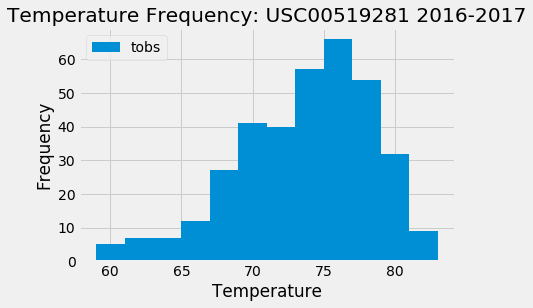

In [66]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt1=session.query(MSM).filter(MSM.station=='USC00519281').\
    filter(func.strftime("%Y-%m-%d", MSM.date)>=dt.date(2016,8,18)).statement
df_281=pd.read_sql_query(stmt1,session.bind)
tobs_281=df_281['tobs']

#plot
tobs_281.plot.hist(bins=12)

#labels
plt.xlabel('Temperature')
plt.legend(['tobs'],loc='upper left')
plt.title('Temperature Frequency: USC00519281 2016-2017')

## Bonus Challenge Assignment

In [68]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):    
    return session.query(func.min(MSM.tobs), func.avg(MSM.tobs), func.max(MSM.tobs)).\
        filter(MSM.date >= start_date).filter(MSM.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [69]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
